In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import datetime, pytz
import seaborn as sns
#import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib import pyplot

In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In D:\ProgramFiles\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.jpeg_quality rcparam was 

In [2]:
# Here We Convert Minutely Data to Daily Form 

def dateparse (time_in_secs):    
    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

## Reading Data and Preparation

In [3]:
df = pd.read_csv("../BTC_Correction_Listing_csv/data.csv",parse_dates=[0], date_parser=dateparse)

In [4]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 16:52:00+00:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 16:53:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 16:54:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 16:55:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 16:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.isnull().sum()

Timestamp                  0
Open                 1243472
High                 1243472
Low                  1243472
Close                1243472
Volume_(BTC)         1243472
Volume_(Currency)    1243472
Weighted_Price       1243472
dtype: int64

In [6]:
df['date'] = pd.to_datetime(df['Timestamp'], format="%Y-%d-%m %H:%M")
df['date'] = pd.to_datetime(df['date'])
df         = df.set_index(['date'])

In [7]:
df.Low[df.Low==1.5]     = 540   # wrong data 
df.Close[df.Close==1.5] = 540   # wrong data
df.fillna(method='ffill', inplace = True)

D:\ProgramFiles\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\ProgramFiles\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
# Close 

df_Close = df[["Close"]]
df_Close = df_Close.resample('D')[['Close']].last()

In [9]:
# Low 

df_Low = df[["Low"]]
df_Low = df_Low.resample('D')['Low'].agg(['min'])

In [10]:
# High

df_High = df[["High"]]
df_High = df_High.resample('D')['High'].agg(['max'])

In [11]:
df_daily = pd.concat([df_Low,df_High,df_Close],axis=1)

In [12]:
df_daily.head()

,min,max,Close
date,,,
2011-12-31 00:00:00+00:00,4.39,4.39,4.39
2012-01-01 00:00:00+00:00,4.39,4.58,4.58
2012-01-02 00:00:00+00:00,4.58,5.00,5.00
2012-01-03 00:00:00+00:00,5.00,5.32,5.26
2012-01-04 00:00:00+00:00,4.93,5.29,5.19


We took these periods to examine in this file. These Periods represent increasment periods only between halving date and ath date. We didn't examine bear market because for us corrections which are in bull market, are important.


2012-12-03 : 2013-11-30 --> Increasment Period 
2016-07-11 : 2017-12-17 --> Increasment Period


In [13]:
firstInc  = df_daily.loc["2012-12-03" : "2013-11-30"]
secondInc = df_daily.loc["2016-07-11" : "2017-12-17"]
#thirdInc  = df_daily.loc["2018-12-16" : "2019-06-26"]
#fourthInc = df_daily.loc["2020-03-12" : "2020-09-14"]

firstInc =firstInc.rename(  columns ={"min": "Low", "max": "High"})
secondInc=secondInc.rename( columns={"min": "Low", "max": "High"})
#thirdInc =thirdInc.rename(  columns ={"min": "Low", "max": "High"})
#fourthInc=fourthInc.rename( columns={"min": "Low", "max": "High"})

season = pd.concat([firstInc,secondInc],axis=0)
season =season.rename(columns={"min": "Low", "max": "High"})

In [14]:
season.head()

,Low,High,Close
date,,,
2012-12-03 00:00:00+00:00,12.32,12.47,12.46
2012-12-04 00:00:00+00:00,12.38,12.78,12.77
2012-12-05 00:00:00+00:00,12.54,13.29,13.29
2012-12-06 00:00:00+00:00,13.05,13.59,13.08
2012-12-07 00:00:00+00:00,13.02,13.56,13.30


### Algorithm

In [15]:
def calculate(season): 
    
    global k
    bottomPrice  = 10000000000    
    peakPrice   = season["Close"][0]
    peakDayDate = season.index[0]
    i = 0

    corrections = {"Peak Date":[],"Peak Price":[],"Bottom Date":[], "Bottom Price" : [] , "Correction Percentage":[] , "Correction Duration":[], "Recovery Duration":[] ,"Peak Date2" :[]}


    for x in range(len(season)-2):

        nextDayDate  = season.index[1 + i]
        nextDayPrice = season.iloc[1 + i]

        if peakPrice >= nextDayPrice["High"]:      

            if bottomPrice > nextDayPrice["Low"]:

                bottomPrice = nextDayPrice["Low"]
                bottomDate  = nextDayDate


        else:

            if (((peakPrice - bottomPrice) /peakPrice))*100 > 15:
                correc = (((peakPrice - bottomPrice) / peakPrice))*100
                corrections["Peak Date"].append('{0:%Y}-{0:%m}-{0:%d} {0:%H}:{0:%M}'.format(peakDayDate, "year","month","day","hour","minute"))
                corrections["Peak Date2"].append(peakDayDate)
                corrections["Peak Price"].append(peakPrice)
                corrections["Bottom Date"].append('{0:%Y}-{0:%m}-{0:%d} {0:%H}:{0:%M}'.format(bottomDate, "year","month","day","hour","minute"))
                corrections["Bottom Price"].append(bottomPrice)
                corrections["Correction Percentage"].append(correc)
                duration = bottomDate - peakDayDate
                corrections["Correction Duration"].append(duration)
                corrections["Recovery Duration"].append(nextDayDate - 1)

            peakPrice  = nextDayPrice["High"]
            peakDayDate= nextDayDate
            bottomPrice = 10000000


        i = i + 1
    for i in range(len(corrections["Peak Date"])):
        
        
        print("%d- Peak Date : %s --> Bottom Date : %s \n    Peak Price : %f      --> Bottom Price : %f  \n    Correction Percentage : %f   \n    Correction Duration : %s Days     Recovery Duration : %s Days "
              %(k,corrections["Peak Date"][i],corrections["Bottom Date"][i],corrections["Peak Price"][i],corrections["Bottom Price"][i],corrections["Correction Percentage"][i],corrections["Correction Duration"][i].days,(corrections["Recovery Duration"][i] - corrections["Peak Date2"][i]).days))
        
            
        print("="*68)
        
        
        k = k +1
        
    return corrections


# We Get the Results Here

In [16]:
k = 1
first = calculate(firstInc)
second = calculate(secondInc)
#third = calculate(thirdInc)
#fourth = calculate(fourthInc)

1- Peak Date : 2013-03-07 00:00 --> Bottom Date : 2013-03-12 00:00 
    Peak Price : 49.170000      --> Bottom Price : 36.000000  
    Correction Percentage : 26.784625   
    Correction Duration : 5 Days     Recovery Duration : 11 Days 
2- Peak Date : 2013-03-22 00:00 --> Bottom Date : 2013-03-23 00:00 
    Peak Price : 76.910000      --> Bottom Price : 50.090000  
    Correction Percentage : 34.871928   
    Correction Duration : 1 Days     Recovery Duration : 3 Days 
3- Peak Date : 2013-03-26 00:00 --> Bottom Date : 2013-03-27 00:00 
    Peak Price : 100.000000      --> Bottom Price : 77.890000  
    Correction Percentage : 22.110000   
    Correction Duration : 1 Days     Recovery Duration : 5 Days 
4- Peak Date : 2013-04-03 00:00 --> Bottom Date : 2013-04-04 00:00 
    Peak Price : 158.410000      --> Bottom Price : 110.000000  
    Correction Percentage : 30.559939   
    Correction Duration : 1 Days     Recovery Duration : 1 Days 
5- Peak Date : 2013-04-05 00:00 --> Bottom Date 

D:\ProgramFiles\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`


## Percentage Graph of Corrections

In [19]:
first_graph = pd.DataFrame.from_dict(first)
second_graph = pd.DataFrame.from_dict(second)
#third_graph = pd.DataFrame.from_dict(third)
#fourth_graph = pd.DataFrame.from_dict(fourth)

correction_Graph = pd.concat([first_graph,second_graph],axis=0)
correction_Graph["Peak Date"] = correction_Graph["Peak Date"].apply(lambda x: x.split(" ")[0])


correction_Graph["Peak Date"] = correction_Graph["Peak Date"].apply(pd.Timestamp)
correction_Graph = correction_Graph.set_index("Peak Date")

D:\ProgramFiles\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


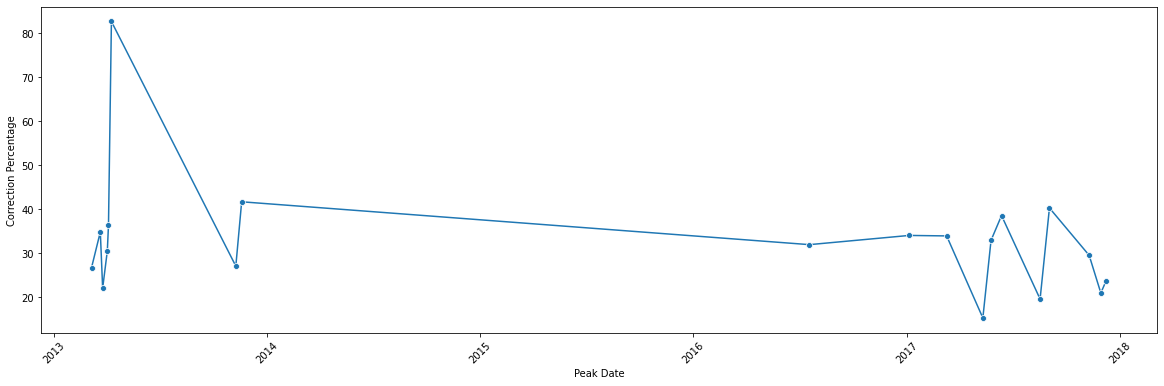

In [20]:
plt.subplots(figsize=(20,6))
plt.xticks(rotation=45)
line = sns.lineplot(data=correction_Graph, x=correction_Graph.index, y="Correction Percentage", marker="o")